# Modelling

## Modelling Techniques

### Clustering

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"   # OpenMP threads
os.environ["MKL_NUM_THREADS"] = "1"   # MKL’s own thread pool

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.sparse import coo_matrix, csr_matrix

In [4]:
import json
import numpy as np
import joblib

In [10]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

host = os.getenv("MY_SQL_HOST")
user = os.getenv("MY_SQL_USER")
password = os.getenv("MY_SQL_PASSWORD")
database = os.getenv("MY_SQL_DATABASE")

In [11]:
import mysql.connector

def get_connection(host, user, password, database):
    mydb = mysql.connector.connect(
      host=host,
      user=user,
      password=password,
      database=database
    )
    return mydb

In [12]:
connection = get_connection(host=host, user=user, password=password, database=database)

In [13]:
cursor = connection.cursor()

In [26]:
root_location = "E:\\applied data science capstone\\anime-recommendation\\modelling\\clustering\\exploration"

In [14]:
query = """
SELECT
    user_id,
    anime_id,
    rating
FROM
    rating_v2
ORDER BY
    user_id;
"""
cursor.execute(query)
raw_data = cursor.fetchall()

In [15]:
df = pd.DataFrame(raw_data, columns=["user_id", "anime_id", "rating"])

In [16]:
df["rating"] = pd.to_numeric(df["rating"])

In [6]:
filename = "E:\\applied data science capstone\\data\\etl\\extract\\transactions\\clustering_13_Jul.csv"

In [17]:
df.to_csv(filename, index=False)

In [18]:
df = pd.read_csv(filename)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47161882 entries, 0 to 47161881
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 1.1 GB


In [20]:
user_cat   = df['user_id'].astype('category')
anime_cat  = df['anime_id'].astype('category')

In [ ]:
# Re‑index users and movies to contiguous 0‑based indices
user_codes = user_cat.cat.codes
anime_codes = anime_cat.cat.codes
data = df['rating'].values

In [22]:
# Build COO, then convert to CSR (row‑compressed)
num_users  = user_codes.max() + 1
num_animes = anime_codes.max() + 1
user_item_sparse = coo_matrix((data, (user_codes, anime_codes)),
                              shape=(num_users, num_animes)).tocsr()

In [23]:
id_to_user = dict(enumerate(user_cat.cat.categories))   # {row → real userId}
id_to_anime = dict(enumerate(anime_cat.cat.categories))  # {col → real movieId}

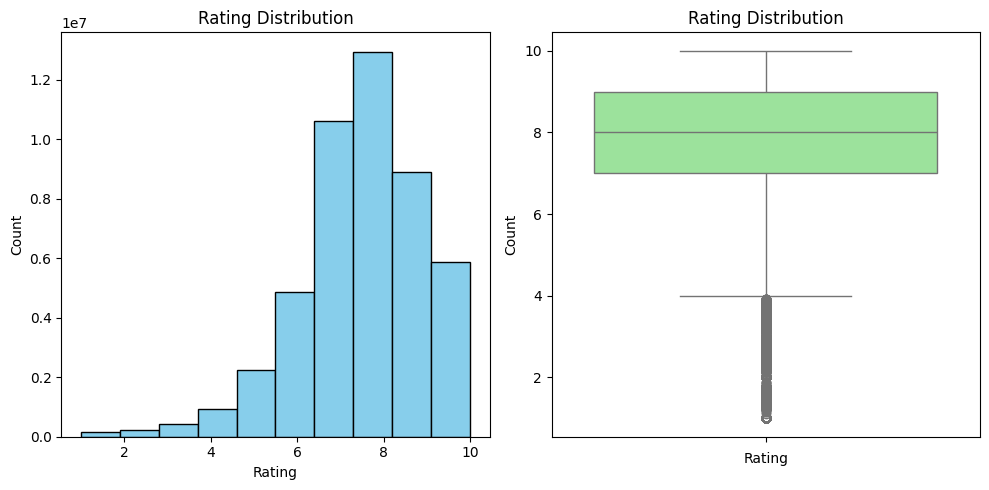

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df["rating"], color="lightgreen")
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\ratings.png")
plt.show()

In [ ]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    print(f"at stage {k}")
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
    
    print("did k means")
    cluster_labels = kmeans.fit_predict(user_item_sparse)

    # print("did cluster predictions means")
    # sil_score = silhouette_score(user_item_sparse, cluster_labels)

    # print("did silhouette scores")
    # silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

at stage 2
did k means
at stage 3
did k means
at stage 4
did k means
at stage 5
did k means
at stage 6
did k means
at stage 7
did k means
at stage 8
did k means
at stage 9
did k means
at stage 10
did k means
at stage 11
did k means
at stage 12
did k means


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

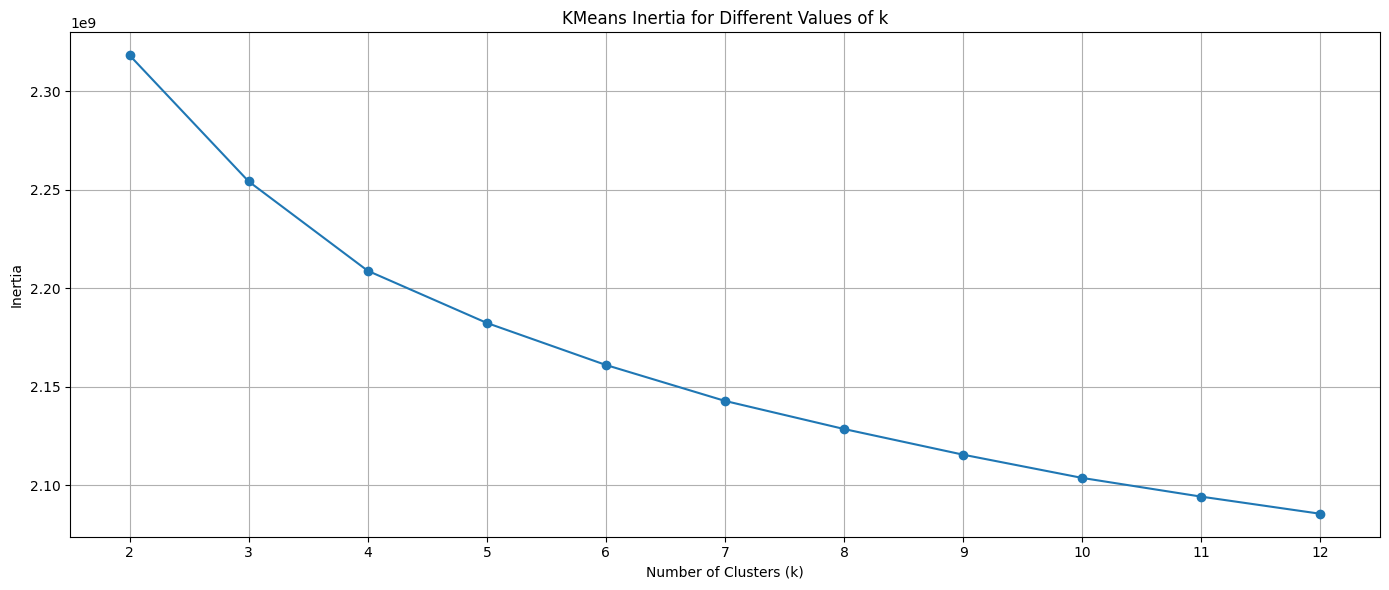

In [30]:
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
# plt.title('Silhouette Scores for Different Values of k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(k_values)
# plt.grid(True)

plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\elbow_method_inertia.png")
plt.show()

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_item_sparse)

# Assign cluster labels back to users
clusters_df = pd.DataFrame({
    'user_id' : [id_to_user[i] for i in range(len(user_clusters))],
    'cluster': user_clusters
})

df_with_cluster = df.merge(clusters_df, on="user_id")

In [ ]:
model_bundle = {
    'kmeans': kmeans,
    'df': df_with_cluster,
    'id_to_user': id_to_user,
    'id_to_anime': id_to_anime
}

# Store to file
joblib.dump(model_bundle, "E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

In [33]:
# Load everything
model_bundle = joblib.load("E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

kmeans = model_bundle['kmeans']
df_with_cluster = model_bundle["df"]

sample_indices = np.random.choice(user_item_sparse.shape[0], size=3000, replace=False)
sample_matrix = user_item_sparse[sample_indices]
sample_labels = user_clusters[sample_indices]

e:\organized-anime-recommendation\organized-anime-recommendation\.venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [34]:
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

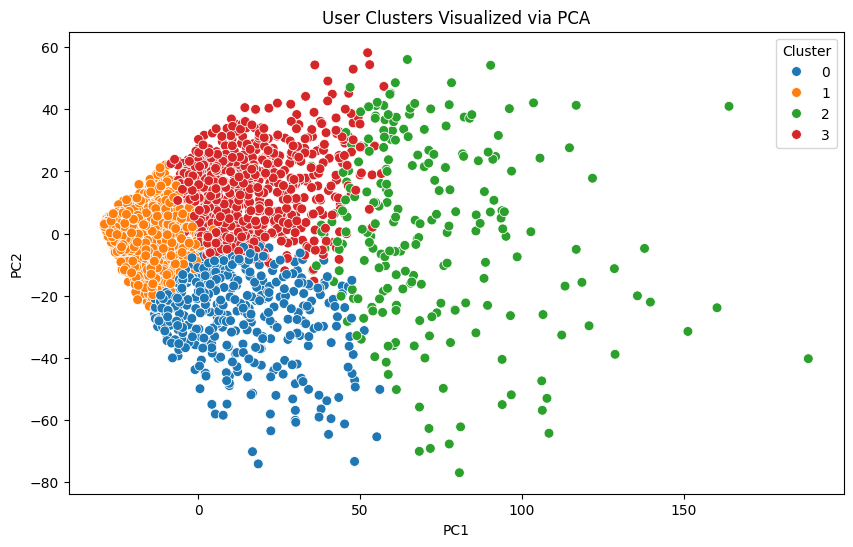

In [35]:
# Step 4: Plot
df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{root_location}\\plots\\user_clusters.png")
plt.show()


### Topic Modelling

In [37]:
import os

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import joblib

In [38]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [41]:
from pymongo import MongoClient

def get_client(uri):
    client = MongoClient(uri)
    return client

In [42]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

uri = os.getenv("MONGO_DB_URI")
# %%
client = get_client(uri)

In [43]:
database = client.get_database("anime_recommendation")
reviews = database.get_collection("reviews")
cursor = reviews.find()

In [45]:
data_lst = []
for item in cursor:
    for rev in item["reviews"]:
        data = {"anime_id": item["anime_id"], "review": rev["review"]}
        data_lst.append(data)

df = pd.DataFrame(data_lst)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201853 entries, 0 to 201852
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   anime_id  201853 non-null  int64 
 1   review    201853 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [47]:
df['processed_review'] = df['review'].apply(preprocess)

In [ ]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
# Fit and transform the processed descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [49]:
# LSA reduces the dimensionality of the TF-IDF matrix while preserving semantic relationships.
# n_components determines the number of topics/latent dimensions.
num_topics = 100
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

In [50]:
# Display the top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()
print("Top words for each LSA Topic:")
for i, comp in enumerate(lsa_model.components_):
    terms_in_comp = [(terms[j], comp[j]) for j in comp.argsort()[-10:][::-1]]
    print(f"Topic {i+1}: {', '.join([t[0] for t in terms_in_comp])}")
print("\n" + "="*50 + "\n")

Top words for each LSA Topic:
Topic 1: anime, character, story, like, really, episode, good, series, season, time
Topic 2: movie, film, series, scene, animation, ghibli, original, shinkai, hour, minute
Topic 3: season, series, arc, second, new, previous, episode, better, fight, titan
Topic 4: anime, season, movie, watch, manga, really, watched, watching, good, amazing
Topic 5: series, story, character, art, great, anime, manga, amazing, overall, episode
Topic 6: really, good, character, pretty, art, sound, story, overall, enjoyment, bad
Topic 7: series, episode, manga, naruto, movie, arc, like, bad, read, filler
Topic 8: series, girl, love, romance, comedy, school, life, cute, really, slice
Topic 9: film, really, manga, like, episode, think, read, love, series, ending
Topic 10: film, series, harem, manga, good, mc, girl, que, pretty, isekai
Topic 11: game, series, really, film, sao, kirito, online, player, watch, anime
Topic 12: que, la, en, el, episode, se, lo, los, una, como
Topic 13

Saving model

In [51]:
model_bundle = {
    'tfidf_matrix': tfidf_matrix,
    'df': df,
    'lsa_model': lsa_model,
    'tfidf_vectorizer': tfidf_vectorizer
}

In [ ]:
joblib.dump(model_bundle, "E:\\applied data science capstone\\topics\\topic_model_v1.joblib")

In [ ]:
model_bundle = joblib.load("E:\\applied data science capstone\\topics\\topic_model_v1.joblib")
df = model_bundle["df"]
lsa_model = model_bundle["lsa_model"]
tfidf_matrix = model_bundle["tfidf_matrix"]
tfidf_vectorizer = model_bundle["tfidf_vectorizer"]